In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

In [2]:
import warnings
# Ignore warnings
warnings.filterwarnings("ignore")


In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
import zipfile
with zipfile.ZipFile('/content/drive/MyDrive/colon_image_sets.zip', 'r') as zip_ref:
    zip_ref.extractall('/content/data/')


In [5]:
import os
import shutil
from sklearn.model_selection import train_test_split
# path of original data
image_set  = "/content/data/colon_image_sets"

In [6]:
# importing libraries
import tensorflow as tf
from tensorflow.keras.layers import Input, Lambda, Dense, Flatten
from tensorflow.keras.models import Model
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator,load_img
from tensorflow.keras.applications import Xception, MobileNet
from tensorflow.keras import layers, models
from tensorflow.keras.models import Sequential
import numpy as np
from glob import glob
import matplotlib.pyplot as plt

### Data Augmentation

In [7]:
SIZE_X = SIZE_Y = 224

datagen = tf.keras.preprocessing.image.ImageDataGenerator(validation_split = 0.2)

train_generator = datagen.flow_from_directory(image_set,
                                       class_mode = "categorical",
                                       target_size = (SIZE_X,SIZE_Y),
                                       color_mode="rgb",
                                       batch_size = 128,
                                       shuffle = False,
                                       subset='training',
                                       seed = 42)

test_generator = datagen.flow_from_directory(image_set,
                                       class_mode = "categorical",
                                       target_size = (SIZE_X, SIZE_Y),
                                       color_mode="rgb",
                                       batch_size = 128,
                                       shuffle = False,
                                       subset='validation',
                                       seed = 42)

Found 8000 images belonging to 2 classes.
Found 2000 images belonging to 2 classes.


# Resnet Model

In [10]:
img_height = img_width = 224

In [12]:
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.callbacks import LearningRateScheduler
from tensorflow.keras import layers, models

# Define ResNet50 model
resnet_model = ResNet50(weights='imagenet', include_top=False, input_shape=(img_height, img_width, 3))

# Freeze the layers
for layer in resnet_model.layers:
    layer.trainable = False

# Build the model
model = models.Sequential([
    resnet_model,
    layers.Flatten(),
    layers.Dense(256, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(2, activation='softmax')  # 2 classes: lung_aca, lung_n
])

# Define RMSprop optimizer with an initial learning rate
initial_learning_rate = 0.001
opt = RMSprop(learning_rate=initial_learning_rate)

# Define a learning rate scheduler function
def lr_scheduler(epoch, lr):
    # Adjust the learning rate
    if epoch % 5 == 0:
        return lr * 0.9
    else:
        return lr

# Create a LearningRateScheduler callback
lr_scheduler_callback = LearningRateScheduler(lr_scheduler)

# Compile the model with RMSprop optimizer
model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model with learning rate scheduler
history = model.fit(train_generator, epochs=10, validation_data=test_generator, callbacks=[lr_scheduler_callback])

# Evaluate the model on the test data
eval_result = model.evaluate(test_generator)
print("Test loss:", eval_result[0])
print("Test accuracy:", eval_result[1])


94765736/94765736 [==============================] - 1s 0us/step
Epoch 1/10
63/63 [==============================] - 75s 1s/step - loss: 20.1848 - accuracy: 0.8311 - val_loss: 0.2640 - val_accuracy: 0.8915 - lr: 9.0000e-04
Epoch 2/10
63/63 [==============================] - 59s 936ms/step - loss: 0.2367 - accuracy: 0.9355 - val_loss: 0.0283 - val_accuracy: 0.9915 - lr: 9.0000e-04
Epoch 3/10
63/63 [==============================] - 59s 925ms/step - loss: 0.2213 - accuracy: 0.9551 - val_loss: 0.0134 - val_accuracy: 0.9940 - lr: 9.0000e-04
Epoch 4/10
63/63 [==============================] - 58s 923ms/step - loss: 0.1230 - accuracy: 0.9716 - val_loss: 0.0165 - val_accuracy: 0.9920 - lr: 9.0000e-04
Epoch 5/10
63/63 [==============================] - 57s 907ms/step - loss: 0.0836 - accuracy: 0.9839 - val_loss: 0.0096 - val_accuracy: 0.9960 - lr: 9.0000e-04
Epoch 6/10
63/63 [==============================] - 68s 1s/step - loss: 0.0551 - accuracy: 0.9891 - val_loss: 0.0101 - val_accuracy: 0.99

In [13]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import numpy as np

def plot_confusion_matrix(y_true, y_pred, classes):
    """
    This function prints and plots the confusion matrix.
    """
    cm = confusion_matrix(y_true, y_pred)
    plt.figure()
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title('Confusion Matrix')
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            plt.text(j, i, format(cm[i, j], fmt),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()


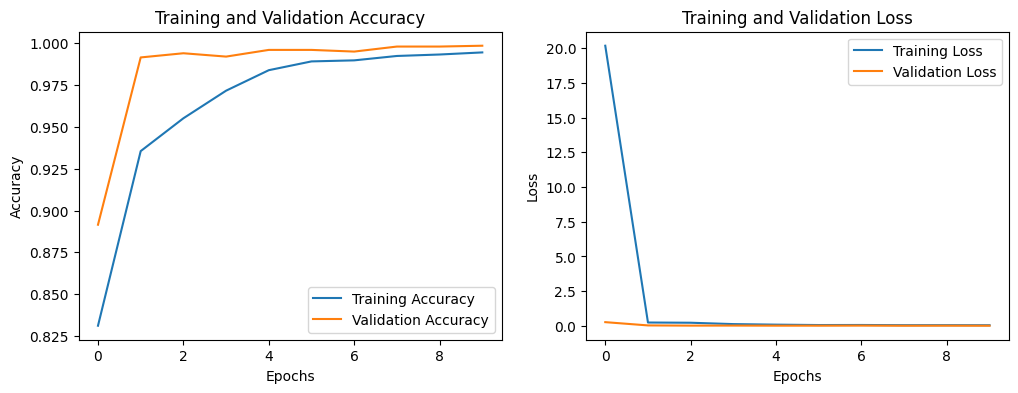

16/16 [==============================] - 20s 1s/step - loss: 0.0062 - accuracy: 0.9985
Test loss: 0.006169993430376053
Test accuracy: 0.9984999895095825
16/16 [==============================] - 14s 746ms/step


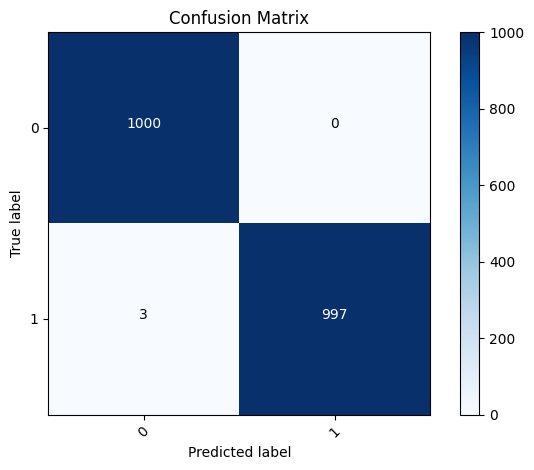

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1000
           1       1.00      1.00      1.00      1000

    accuracy                           1.00      2000
   macro avg       1.00      1.00      1.00      2000
weighted avg       1.00      1.00      1.00      2000



In [14]:
# Plot training and validation accuracy
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Plot training and validation loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

# Evaluate the model on the test data
eval_result = model.evaluate(test_generator)
print("Test loss:", eval_result[0])
print("Test accuracy:", eval_result[1])

# Predict the classes for the test data
y_pred = model.predict(test_generator)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true_classes = test_generator.classes

# Plot confusion matrix
plot_confusion_matrix(y_true_classes, y_pred_classes, classes=np.unique(y_true_classes))
plt.show()

# Print classification report
print('Classification Report:')
print(classification_report(y_true_classes, y_pred_classes))


### b) CNN model

In [ ]:
img_height = img_width = 224

In [15]:
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.callbacks import LearningRateScheduler
from tensorflow.keras import layers, models

# Build the CNN model
model = models.Sequential([
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=(img_height, img_width, 3)),
    layers.MaxPooling2D(2, 2),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D(2, 2),
    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.MaxPooling2D(2, 2),
    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.MaxPooling2D(2, 2),
    layers.Flatten(),
    layers.Dropout(0.5),
    layers.Dense(512, activation='relu'),
    layers.Dense(2, activation='softmax')  # 2 classes: lung_aca, lung_n
])

# Define RMSprop optimizer with an initial learning rate
initial_learning_rate = 0.001
opt = RMSprop(learning_rate=initial_learning_rate)

# Define a learning rate scheduler function
def lr_scheduler(epoch, lr):
    # Adjust the learning rate
    if epoch % 5 == 0:
        return lr * 0.9
    else:
        return lr

# Create a LearningRateScheduler callback
lr_scheduler_callback = LearningRateScheduler(lr_scheduler)

# Compile the model with RMSprop optimizer
model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model with learning rate scheduler
history = model.fit(train_generator, epochs=10, validation_data=test_generator, callbacks=[lr_scheduler_callback])

# Evaluate the model on the test data
eval_result = model.evaluate(test_generator)
print("Test loss:", eval_result[0])
print("Test accuracy:", eval_result[1])


Epoch 1/10
63/63 [==============================] - 61s 893ms/step - loss: 444.2173 - accuracy: 0.4276 - val_loss: 0.6931 - val_accuracy: 0.5000 - lr: 9.0000e-04
Epoch 2/10
63/63 [==============================] - 54s 846ms/step - loss: 0.6946 - accuracy: 0.4169 - val_loss: 0.6931 - val_accuracy: 0.5000 - lr: 9.0000e-04
Epoch 3/10
63/63 [==============================] - 53s 837ms/step - loss: 5.7673 - accuracy: 0.5029 - val_loss: 0.6931 - val_accuracy: 0.5000 - lr: 9.0000e-04
Epoch 4/10
63/63 [==============================] - 52s 828ms/step - loss: 0.6936 - accuracy: 0.4349 - val_loss: 0.6931 - val_accuracy: 0.5000 - lr: 9.0000e-04
Epoch 5/10
63/63 [==============================] - 52s 828ms/step - loss: 1.0605 - accuracy: 0.4400 - val_loss: 0.6931 - val_accuracy: 0.5000 - lr: 9.0000e-04
Epoch 6/10
63/63 [==============================] - 53s 841ms/step - loss: 0.6936 - accuracy: 0.5000 - val_loss: 0.6932 - val_accuracy: 0.5000 - lr: 8.1000e-04
Epoch 7/10
63/63 [====================

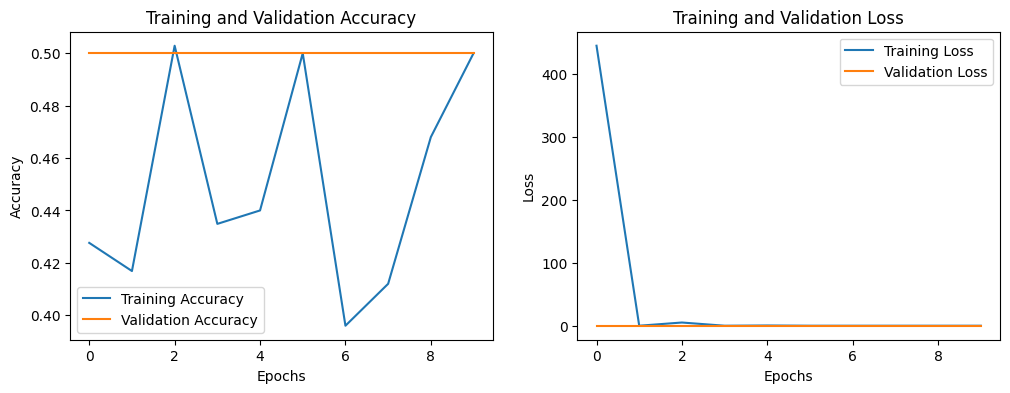

16/16 [==============================] - 11s 653ms/step - loss: 0.6932 - accuracy: 0.5000
Test loss: 0.693153977394104
Test accuracy: 0.5
16/16 [==============================] - 10s 617ms/step


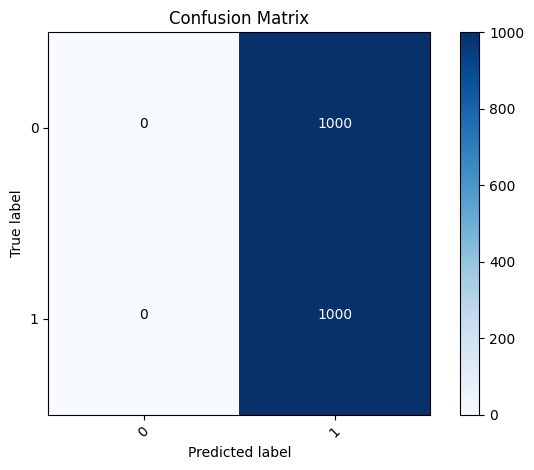

Classification Report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00      1000
           1       0.50      1.00      0.67      1000

    accuracy                           0.50      2000
   macro avg       0.25      0.50      0.33      2000
weighted avg       0.25      0.50      0.33      2000



In [16]:
# Plot training and validation accuracy
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Plot training and validation loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

# Evaluate the model on the test data
eval_result = model.evaluate(test_generator)
print("Test loss:", eval_result[0])
print("Test accuracy:", eval_result[1])

# Predict the classes for the test data
y_pred = model.predict(test_generator)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true_classes = test_generator.classes

# Plot confusion matrix
plot_confusion_matrix(y_true_classes, y_pred_classes, classes=np.unique(y_true_classes))
plt.show()

# Print classification report
print('Classification Report:')
print(classification_report(y_true_classes, y_pred_classes))
